# Introduction

In this notebook, I will develop a system for forecasting influenza viral evolution. More specifically, I would like to predict the probability distribution over new influenza sequences, given current sequences.

## Use Case

This data product uses my background knowledge of influenza evolution and marries it with recent skills picked up in deep learning to try to forecast future influenza sequences. This is potentially a long-term competitive advantage for a company building out vaccines against fast-evolving viruses, and more generally, a long-term competitive advantage for public health.

Borrowing a quote from one of the great ice hockey players,

> I skate to where the puck will be, not where it has already been. (Wayne Gretzky)

## Data

The data come from the [influenza research database ](https://www.fludb.org/)(IRD). Search parameters were as follows:

- Data Type: Protein
- Virus Type: A
- Subtype: H3N2
- Date Range: From 2000
- 'Classical' Proteins: Complete? HA

No other search parameters were used. Data were downloaded on 31 May 2017.

## Learning Strategy

1. Use variational autoencoders, a deep learning method, to learn a latent manifold on which sequence evolution is taking place. 
1. Simultaneously construct a genotype network of flu evolution.
    1. Nodes: Influenza HA protein sequences.
    1. Edges: Sequences differ by one amino acid.
1. Sanity checks:
    1. Plot edit distance between any two random pairs of protein sequences against their manifold distance. There should be a linear relationship between the two.
1. Validation:
    1. MVP validation will be done by doing one round of "back testing" - we hold out 2017 data, and predict whether 2017 data shows up or not.
    
    
## Technical aspects demonstrated

1. Deep learning.
1. Basic time series analysis.
1. Genomics.

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm
import GPflow

plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from custom import load_model
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from random import sample

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from pymc3 import gp
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import encode_array, save_model, get_density_interval
from utils.data import load_sequence_and_metadata

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first will start with doing some basic cleaning of the data.

1. We want to make sure that there's only human flu sequences. The dataset may contain non-flu sequences.
1. We want to forecast 2017 sequences. Therefore, any machine learning fitting can only be done on the data up to 2016; any predictions are to be done on 2017 sequences.

In [367]:
# Let's start by loading the protein sequence FASTA file and metadata.
sequences, metadata = load_sequence_and_metadata(kind='csv')
assert len(sequences) == len(metadata)

# Filter for just human sequences, then split into training and test set.
metadata = metadata[metadata['Host Species'] == 'IRD:Human']
training_metadata = metadata[metadata['Collection Date'] < datetime(2017, 1, 1)]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

test_metadata = metadata[metadata['Collection Date'] >= datetime(2017, 1, 1)]
test_idxs = [i for i, s in enumerate(sequences) if s.id in test_metadata['Sequence Accession'].values]

# Encode as array.
sequence_array = encode_array(sequences)
training_array = sequence_array[training_idxs]
test_array = sequence_array[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences[i] for i in test_idxs]

load_sequence_and_metadata() took 0:00:01.972372 seconds.
24


To visualize what's going on, let's display the data below.

In [368]:
test_array   # the one-of-K encoding of sequences.

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [369]:
training_array  # also a one-of-K encoding of sequences

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Some sanity checks implemented below:

1. Length of training (or testing) array is the same as the metadata.

In [370]:
# Sanity checks
assert len(training_array) == len(training_metadata)
assert len(test_array) == len(test_metadata)

# Diagnostic prints that may be helpful later
print(training_array.shape)

(13373, 13680)


Let's now build the variational autoencoder model. This is a deep learning model that provides us with a way to learn a latent representation of discrete sequence space as a continuous representation instead. It's both a visualization tool and a deep learning data compression tool.

In [371]:
# # Set up VAE.
# with tf.device('/gpu:0'):
#     intermediate_dim = 1000
#     encoding_dim = 3
#     latent_dim = encoding_dim
#     epsilon_std = 1.0
#     nb_epoch = 250

#     x = Input(shape=(training_array.shape[1],))
#     z_mean = Dense(latent_dim)(x)
#     z_log_var = Dense(latent_dim)(x)

#     def sampling(args):
#         z_mean, z_log_var = args
#         epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
#                                   stddev=epsilon_std)
#         return z_mean + K.exp(z_log_var / 2) * epsilon


#     def vae_loss(x, x_decoded_mean):
#         xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
#         kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         return xent_loss + kl_loss

#     z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#     x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

#     vae = Model(x, x_decoded_mean)
#     vae.compile(optimizer='adam', loss=vae_loss)

#     # build a model to project inputs on the latent space
#     encoder = Model(x, z_mean)
#     encoder_var = Model(x, z_log_var)

#     x_train, x_test = train_test_split(training_array)

#     early_stopping = EarlyStopping(monitor="val_loss", patience=2)


#     # build the decoder
#     encoded_input = Input(shape=(encoding_dim,))
#     # retrieve the last layer of the autoencoder model
#     decoder_layer = vae.layers[-1]
#     # create the decoder model
#     decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


#     # Train the VAE to learn weights
#     vae.fit(x_train, x_train,
#             shuffle=True,
#             epochs=nb_epoch,
#             validation_data=(x_test, x_test),
#             callbacks=[early_stopping],
#            )

# Putting VAEs into Production

How might we put the VAE into production? Keras allows us to save and load models as `.h5` and `.json` files. (Reference [here](http://machinelearningmastery.com/save-load-keras-deep-learning-models/).)

I will save the model as it is right now under the `trained_models/` directory.

In [372]:
# save_model(vae, 'trained_models/vae')
# save_model(encoder, 'trained_models/encoder')
# save_model(decoder, 'trained_models/decoder')

In [373]:
# with open('trained_models/vae.yaml', 'r+') as f:
#     yaml_spec = f.read()

In [374]:
vae = load_model('trained_models/vae')
encoder = load_model('trained_models/encoder')
decoder = load_model('trained_models/decoder')

In [375]:
training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

(13373, 3)

Let's compute the convex hull of the `test_embedding` points, so that it can be laid over the `training_embedding` points.

In [376]:
test_embeddings_mean = encoder.predict(test_array)
test_embeddings_hull = ConvexHull(test_embeddings_mean)

Before moving on, save test embeddings and training embeddings to disk

In [377]:
pd.DataFrame(test_embeddings_mean)

,0,1,2
0,-0.169175,-1.476121,1.758001
1,-0.822338,-1.677743,3.001601
2,-0.934565,-1.852435,2.426434
3,-0.144333,-1.715674,1.810452
4,-0.140226,-1.707515,2.105132
5,-0.140226,-1.707515,2.105132
6,-0.822338,-1.677743,3.001601
7,-0.822338,-1.677743,3.001601
8,-0.347295,-1.357930,1.691708
9,-0.140226,-1.707515,2.105132


In [378]:
lowp, highp = get_density_interval(99, training_embeddings_mean, axis=0)
lowp, highp

(array([-1.6280247 , -4.0219806 , -0.79145813]),
 array([ 3.00617099,  0.32198843,  3.30450177]))

In [379]:
# lowp, highp = get_density_interval(97.5, test_embeddings_mean, axis=0)
# lowp, highp

Let's visualize the latent space, which is currently encoded in 3 dimensions.

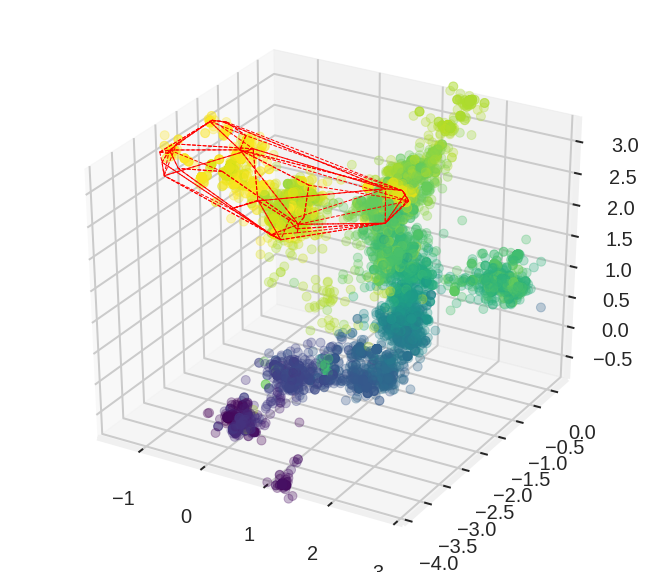

In [380]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(training_embeddings_mean[:, 0], 
           training_embeddings_mean[:, 1], 
           training_embeddings_mean[:, 2], 
           c=training_metadata['Collection Date'], cmap='viridis')
# Plot the convex hull of the 2017 sequences.
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_embeddings_mean[simplex, 0], 
            test_embeddings_mean[simplex, 1], 
            test_embeddings_mean[simplex, 2], 'r--', lw=0.5)
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
ax.set_facecolor('white')
plt.show()

Let's save the learned coordinates to disk, so that it can be visualized in a separate file. Uncomment the cell if new training happened, and the coordinates need to be updated.

In [381]:
training_metadata.head()

,Name,Sequence Accession,Complete Genome,Segment,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name,Unnamed: 12
0,HA,HM628693,No,4,1701,H3N2,2010-03-03,IRD:Human,Brazil,-N/A-,-N/A-,A/Acre/15093/2010(H3N2),NaN
1,HA,HM628694,No,4,1701,H3N2,2010-04-04,IRD:Human,Brazil,-N/A-,-N/A-,A/Acre/26954/2010(H3N2),NaN
2,HA,KT889256,Yes,4,1701,H3N2,2013-09-26,IRD:Human,Ethiopia,-N/A-,-N/A-,A/Addis Ababa/1514A07305892N/2013,NaN
3,HA,KC882982,No,4,1701,H3N2,2011-01-05,IRD:Human,USA,Alabama,10-11,A/Alabama/01/2011,NaN
4,HA,KT841229,Yes,4,1701,H3N2,2015-01-06,IRD:Human,USA,Alabama,14-15,A/Alabama/01/2015,NaN


In [382]:
training_metadata.loc[:, 'coords0'] = training_embeddings_mean[:, 0]
training_metadata.loc[:, 'coords1'] = training_embeddings_mean[:, 1]
training_metadata.loc[:, 'coords2'] = training_embeddings_mean[:, 2]
training_metadata.tail()
# training_metadata.to_csv('data/metadata_with_embeddings.csv')

/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Name,Sequence Accession,Complete Genome,Segment,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name,Unnamed: 12,coords0,coords1,coords2
16977,HA,KJ567656,No,4,1701,H3N2,2012-04-18,IRD:Human,China,-N/A-,-N/A-,A/Zhongshan/01/2012,NaN,1.193005,-1.211505,2.009971
16978,HA,KJ567658,No,4,1701,H3N2,2013-10-21,IRD:Human,China,-N/A-,-N/A-,A/Zhongshan/01/2013,NaN,1.327763,-0.830435,2.577444
16979,HA,KJ567655,No,4,1701,H3N2,2011-08-08,IRD:Human,China,-N/A-,-N/A-,A/Zhongshan/02/2011,NaN,2.722208,-1.042558,1.311242
16980,HA,KJ567657,No,4,1701,H3N2,2012-04-18,IRD:Human,China,-N/A-,-N/A-,A/Zhongshan/02/2012,NaN,1.223866,-1.283524,2.154933
16981,HA,KJ567659,No,4,1701,H3N2,2013-10-21,IRD:Human,China,-N/A-,-N/A-,A/Zhongshan/02/2013,NaN,1.327763,-0.830435,2.577444


# Sanity Check 1: Distances

I want to do a sanity check on the protein sequences. The goal here is to figure out whether short embedding euclidean distances roughly equals to short Levenshtein distances between sequences. I will sample 1000 pairs of sequences, compute their Levenshtein distance and their euclidean distances, and check that there is a linear relationship between the two.

In [383]:
# Generate pairs of random indices.
indices = np.random.randint(low=0, high=len(training_array), size=(1000, 2))
indices

array([[ 1614, 10334],
       [ 9737, 11399],
       [  938,   780],
       ..., 
       [ 9154,  8958],
       [ 4903,  9467],
       [ 5359,  1792]])

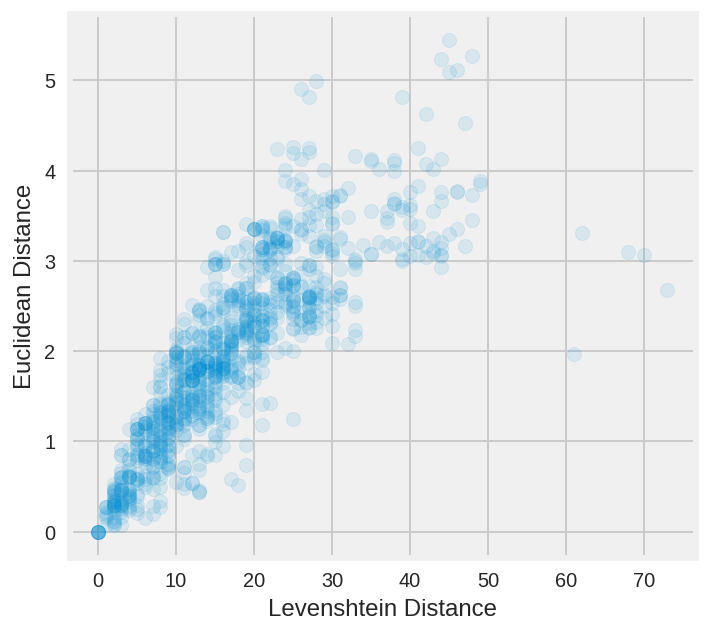

In [384]:
lev_dists = []
euc_dists = []
for i1, i2 in indices:
    lev_dist = levD(str(training_sequences[i1].seq), str(training_sequences[i2].seq))
    euc_dist = eucD(training_embeddings_mean[i1], training_embeddings_mean[i2])
    
    lev_dists.append(lev_dist)
    euc_dists.append(euc_dist)
    
fig = plt.figure(figsize=(5,5))
plt.scatter(lev_dists, euc_dists, alpha=0.1)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Euclidean Distance')

## Sanity Check Conclusion
Regardless of what indices are sampled, we will generally get back a linear relationship between Euclidean and Levenshtein distances. I feel good about this sanity check.

## Visualize Evolutionary Trajectory over Time

I'm now going to try visualizing the evolutionary trajectory of the HA protein, day-by-day. We will take the average coordinate per day, and plot them in 3D space.

In [385]:
from ipywidgets import interact
from ipywidgets.widgets import Dropdown

tm_coords = deepcopy(training_metadata)  # tm_coords means "training metadata with coordinates"
tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median()\
                            .resample("D").median().dropna().reset_index()

avg_coords_by_quarter = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("Q").median().dropna().reset_index()

        
avg_coords_by_week = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].median().\
                            resample("W").median().dropna().reset_index()

@interact(elev=(-180, 180, 10), azim=(0, 360, 10))
def plot_daily_avg(elev, azim):

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.scatter(xs=avg_coords_by_week['coord0'],
                ys=avg_coords_by_week['coord1'],
                zs=avg_coords_by_week['coord2'],
                c=avg_coords_by_week['Collection Date'], 
                cmap='viridis')
    ax1.view_init(elev, azim)
    ax1.set_title('by day')
    
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.scatter(xs=avg_coords_by_quarter['coord0'], 
                ys=avg_coords_by_quarter['coord1'], 
                zs=avg_coords_by_quarter['coord2'], 
                c=avg_coords_by_quarter['Collection Date'], 
                cmap='viridis')
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title('by quarter')
    
    ax1.set_xlim(ax2.get_xlim())
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_zlim(ax2.get_zlim())
    
    for simplex in test_embeddings_hull.simplices:
        ax1.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
        
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    plt.show()


Looking at the data, it looks most feasible to try predicting coordinates for the coming **months**, particularly trying to go out 3-6 months.

Let's transform the 3D plots into three 1D plots. (This is just a viz aid.)

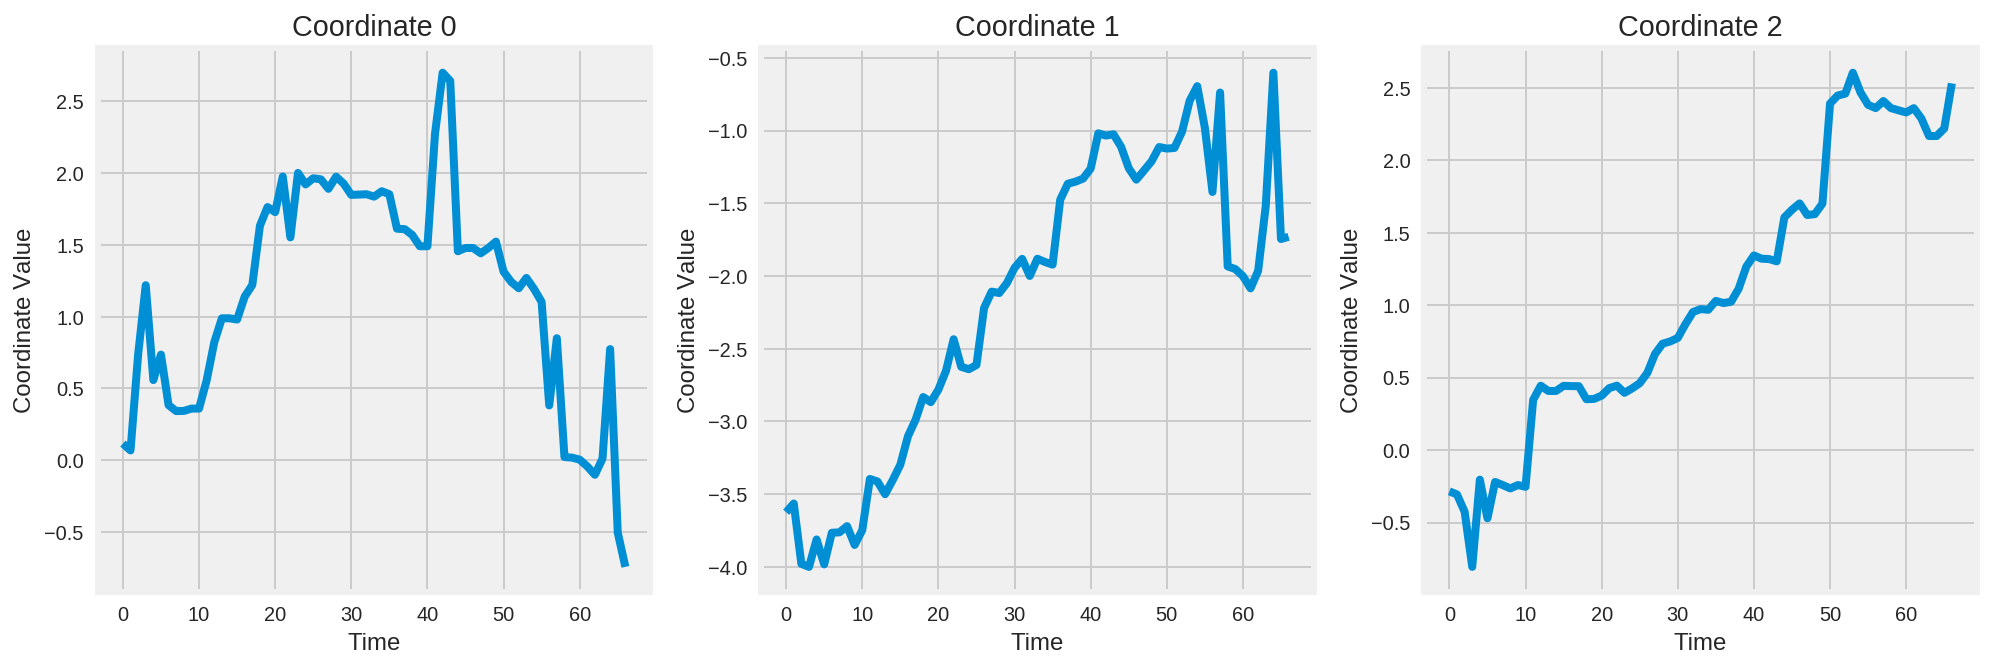

In [386]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_quarter['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_quarter['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_quarter['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

# GP for Timeseries

Here's me trying out GPs for time series. I've hacked this once before, following an example, so maybe it's transferrable...

In [387]:
import theano.tensor as tt
x_vals = np.array(range(len(avg_coords_by_quarter))).reshape(-1, 1).astype('float32')

def build_coords_model(coordinate):
    y_vals = avg_coords_by_quarter[coordinate].values.astype('float32')
    
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)

        y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
                         observed={'X':x_vals, 
                                   'Y':y_vals})
        trace = pm.sample(2000)

        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
        gp_samples = pm.gp.sample_gp(trace=trace, gp=y_obs, X_values=pp_x, samples=1000)

    return gp_samples

Now with the function defined, let's train three separate GP models to predict the evolutionary coordinates over time.

In [388]:
coord0_preds = build_coords_model('coord0')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = -38.676: 100%|██████████| 200000/200000 [02:43<00:00, 1221.92it/s]   
Finished [100%]: Average ELBO = -38.682
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:23<00:00, 42.81it/s]


In [389]:
coord1_preds = build_coords_model('coord1')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = -26.999: 100%|██████████| 200000/200000 [02:48<00:00, 1188.19it/s]   
Finished [100%]: Average ELBO = -27.005
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:23<00:00, 42.54it/s]


In [390]:
coord2_preds = build_coords_model('coord2')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = 5.1491: 100%|██████████| 200000/200000 [02:49<00:00, 1179.82it/s]
Finished [100%]: Average ELBO = 5.1616
Evidence of divergence detected, inspect ELBO.
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:26<00:00, 38.26it/s]


In [391]:
coord0_preds.shape, coord1_preds.shape, coord2_preds.shape, 

((1000, 69), (1000, 69), (1000, 69))

Now, we can plot the coordinates with the ground truth data.

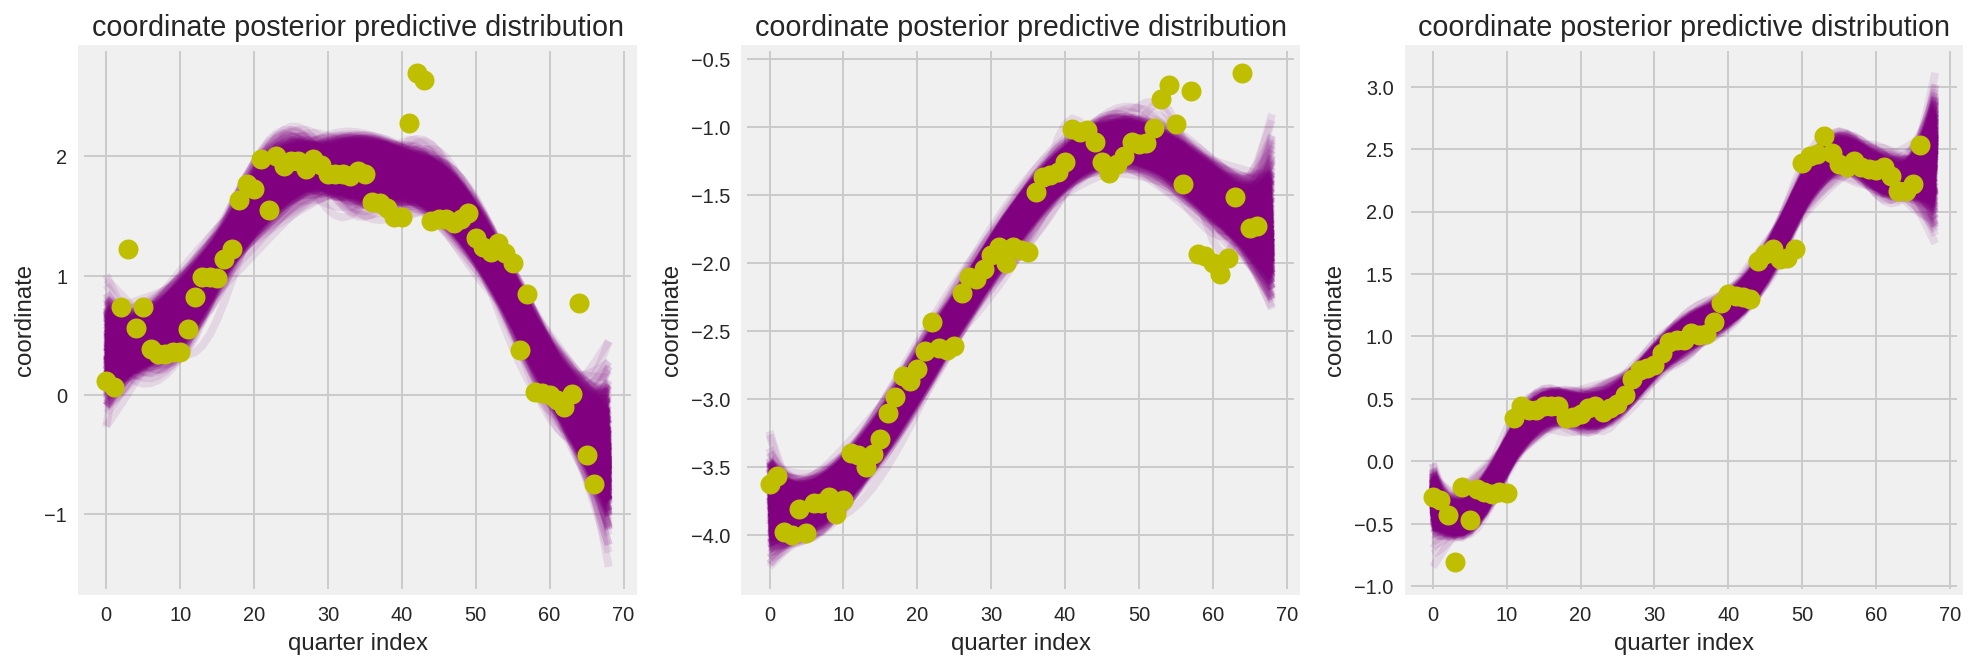

In [392]:
from random import sample
def plot_coords_with_groundtruth(coord_preds, data, ax):
    pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
    for x in coord_preds:
        ax.plot(pp_x, x, color='purple', alpha=0.1)
    ax.plot(x_vals, data, 'oy', ms=10);
    ax.set_xlabel("quarter index");
    ax.set_ylabel("coordinate");
    ax.set_title("coordinate posterior predictive distribution");
    
    return ax

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
plot_coords_with_groundtruth(coord0_preds, avg_coords_by_quarter['coord0'], ax0)
plot_coords_with_groundtruth(coord1_preds, avg_coords_by_quarter['coord1'], ax1)
plot_coords_with_groundtruth(coord2_preds, avg_coords_by_quarter['coord2'], ax2)


I'd like to try making a Bokeh plot of this.

In [409]:
test_coords_embed = deepcopy(test_metadata)
test_coords_embed['coord0'] = test_embeddings_mean[:, 0]
test_coords_embed['coord1'] = test_embeddings_mean[:, 1]
test_coords_embed['coord2'] = test_embeddings_mean[:, 2]
test_coords_embed = test_coords_embed.set_index('Collection Date').resample('Q').mean().reset_index()
test_coords_embed.to_csv('data/test_metadata_with_embeddings.csv')
test_coords_embed

,Collection Date,Segment,Segment Length,Unnamed: 12,coord0,coord1,coord2
0,2017-03-31,4.0,1734.832853,NaN,-0.700494,-1.664800,2.457307
1,2017-06-30,4.0,1737.000000,NaN,-0.536831,-1.530502,2.380945


In [414]:
# test_coords_embed[['coord0', 'coord1', 'coord2']].values
decoder.predict(test_coords_embed[['coord0', 'coord1', 'coord2']].values)

array([[  8.27948770e-06,   8.13587394e-06,   8.28455086e-06, ...,
          8.18558965e-06,   8.26399446e-06,   8.14564100e-06],
       [  1.08876475e-05,   1.07061132e-05,   1.08432678e-05, ...,
          1.08219147e-05,   1.09386965e-05,   1.07924889e-05]], dtype=float32)

Make distribution plot that shows where the forecasts show up on the 95% credible interval.

In [416]:
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.layouts import row

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

def percentile_xy(x, y, perc):
    return np.percentile(x, perc), np.percentile(y, perc)


def plot_forecast_hpd(coord_preds, coords_test, c, quarter):
    
    
    x, y = ecdf(coord_preds[:, -3+quarter])
    y_perc = (y * 100).astype('int')
    df = pd.DataFrame(dict(x=x, y=y, y_perc=y_perc))
    
    df['color'] = df['y_perc'].apply(lambda x: 'red' if x > 2.5 and x < 97.5 else 'blue')
    src = ColumnDataSource(df)

    
    # Instantiate Figure
    p = figure(plot_width=300, plot_height=300, 
               x_axis_label="coordinate value", y_axis_label="cumulative distribution",
               title="")

    # Make scatter plot.
    p.scatter('x', 'y', 
              color='color',
              source=src)
    p.ray(x=[coords_test['coord{0}'.format(c)][quarter-1]], y=[0], angle=np.pi / 2, length=0, line_width=2, color='blue')
#     p.scatter(*percentile_xy(x, y, 2.5), color='red')
#     p.scatter(*percentile_xy(x, y, 97.5), color='red')

    # Add Hover tool
    hovertool = HoverTool()
    hovertool.tooltips = [
        ("Value", "@x"),
        ("Percentile", "@y_perc")
    ]
    p.add_tools(hovertool)

    return p

q = 2
p0 = plot_forecast_hpd(coord0_preds, test_coords_embed, 0, quarter=q)
p1 = plot_forecast_hpd(coord1_preds, test_coords_embed, 1, quarter=q)
p2 = plot_forecast_hpd(coord2_preds, test_coords_embed, 2, quarter=q)

show(row(p0, p1, p2))

Decode the hold-out coordinates and check where they are in the forecasted sequences.

In [423]:
output_notebook()

p = figure(plot_width=300, plot_height=300, x_axis_label='Calendar Quarter', y_axis_label='Coordinate Value')
pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
for x in sample(range(len(coord0_preds)), 100):
    p.line(pp_x.reshape(-1), coord0_preds[x], color='purple', alpha=0.1)
p.circle(x_vals.reshape(-1), avg_coords_by_quarter['coord0'], color='orange')
p.circle(pp_x[-2:].reshape(-1), test_coords_embed['coord0'], color='blue')
show(p)

Loading BokehJS ...

We can see that the GPs learned the time-varying function pretty accurately, with some outliers smoothed out. Additionally, the uncertainty surrounding the two quarter forward predictions (right-most side of each plot) fan out, but not too much either. We can sample from these coordinates and generate back new sequence predictions.

In [424]:
one_quarter_pred = np.array([coord0_preds[:, -2], coord1_preds[:, -2], coord2_preds[:, -2]]).T
two_quarter_pred = np.array([coord0_preds[:, -1], coord1_preds[:, -1], coord2_preds[:, -1]]).T

# Grab out the 95% HPD interval from the data, filter out the data that are outside of HPD
oneQ_low, oneQ_high = get_density_interval(95, one_quarter_pred)
oneQ_low, oneQ_high

(array([-0.81481089, -2.0716895 ,  2.07563536]),
 array([  1.64616269e-03,  -1.37735577e+00,   2.65616666e+00]))

Sanity check to see what `one_quarter_pred` looks like.

In [425]:
one_quarter_pred

array([[-0.22533602, -1.81781203,  2.07353906],
       [-0.23686901, -1.37654179,  2.16634588],
       [-0.29916472, -1.64404162,  2.69969378],
       ..., 
       [-0.1421011 , -1.93666375,  2.36000013],
       [-0.34343446, -1.71038549,  2.45056756],
       [-0.3791557 , -1.6089714 ,  2.64149927]])

In [426]:
test_embeddings_mean

array([[-0.16917507, -1.47612083,  1.75800097],
       [-0.8223381 , -1.67774343,  3.00160122],
       [-0.93456453, -1.85243511,  2.42643428],
       ..., 
       [-1.53378665, -2.12063313,  2.74607778],
       [-1.21032155, -2.20410991,  2.56491613],
       [-1.53378665, -2.12063313,  2.74607778]], dtype=float32)

Compute the convex hull of the scatter points, and check to see whether the 2017 two quarters are within the predicted convex hull.

In [427]:
oneQ_hull = ConvexHull(one_quarter_pred)
twoQ_hull = ConvexHull(two_quarter_pred)

In [428]:
oneQ_hull.vertices

array([ 35,  63,  99, 116, 176, 242, 255, 256, 279, 330, 390, 407, 408,
       446, 474, 492, 498, 505, 518, 569, 575, 577, 609, 614, 647, 648,
       656, 702, 736, 746, 782, 803, 871, 875, 919, 923, 941, 982, 985], dtype=int32)

Quick sanity check - vary "dim" from 0-2; and check against test_coords_embed above: are they within the "cube" that is formed by convex hull vertices? (Granted: there's better methods for checking whether the predicted "average" sequence is within the convex hull, but this is quick-and-dirty.

In [429]:
dim = 2
one_quarter_pred[oneQ_hull.vertices][:, dim].min(), one_quarter_pred[oneQ_hull.vertices][:, dim].max()
# two_quarter_pred[twoQ_hull.vertices][:, dim].min(), two_quarter_pred[twoQ_hull.vertices][:, dim].max()

(1.8668841031409968, 2.8441310934452693)

In [430]:
from ipywidgets import IntSlider
# @interact(elev=range(-180, 180, 20), azim=range(0, 360, 20))
def plot_predicted_coords(elev, azim):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
               test_coords_embed['coord2'], s=200)
    # ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
    # ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
    ax.set_facecolor('white')
    ax.view_init(elev=elev, azim=azim)
    
    for simplex in oneQ_hull.simplices:
        ax.plot(one_quarter_pred[simplex, 0], 
                 one_quarter_pred[simplex, 1], 
                 one_quarter_pred[simplex, 2], 
                 'b-', lw=0.2)
    plt.show()
    
elev_slider = IntSlider(value=0, min=-180, max=180, step=20)
azim_slider = IntSlider(value=60, min=0, max=360, step=20)
interact(plot_predicted_coords, elev=elev_slider, azim=azim_slider)

<function __main__.plot_predicted_coords>

Now, let's try sampling out sequences from this coordinate space.

In [431]:
from custom import embedding2binary, binary2chararray
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [432]:
from collections import Counter

def embedding2seqs(decoder, preds, sequences):
    binary = embedding2binary(decoder, preds)
    chararray = binary2chararray(sequences, binary)
    strs = [''.join(i for i in k) for k in chararray]
    strcounts = Counter(strs)
    seqrecords = []
    for s, c in sorted(strcounts.items(), key=lambda x: x[1], reverse=True):
        s = Seq(s)
        sr = SeqRecord(s, id='weight_' + str(c))
        seqrecords.append(sr)
        
    return binary, chararray, strcounts, strs, seqrecords
    
oneQ_binary, oneQ_chararray, oneQ_strcounts, oneQ_strs, oneQ_seqrecords = embedding2seqs(decoder, one_quarter_pred, sequences)
twoQ_binary, twoQ_chararray, twoQ_strcounts, twoQ_strs, twoQ_seqrecords = embedding2seqs(decoder, two_quarter_pred, sequences)

In [433]:
twoQ_strcounts.keys()

dict_keys(['MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICIAAAA', 'MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYTYPALNVTMPNKEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKE

In [434]:
# oneQ_binary = embedding2binary(decoder, one_quarter_pred)
# oneQ_chararray = binary2chararray(sequences, oneQ_binary)

In [435]:
# twoQ_binary = embedding2binary(decoder, two_quarter_pred)
# twoQ_chararray = binary2chararray(sequences, twoQ_binary)

Now, we can save the data to disk.

In [436]:

# # Data structure here: 
# oneQ_strs = Counter([''.join(i for i in k) for k in oneQ_chararray])

# oneQ_seqrecords = []
# for s, c in sorted(oneQ_strs.items(), key=lambda x: x[1], reverse=True):
#     s = Seq(s)
#     sr = SeqRecord(s, id='weight_' + str(c))
#     oneQ_seqrecords.append(sr)
    
# # Write to disk
SeqIO.write(oneQ_seqrecords, 'data/oneQ_predictions.fasta', 'fasta')
SeqIO.write(twoQ_seqrecords, 'data/twoQ_predictions.fasta', 'fasta')

16

In [437]:
test_binarray = embedding2binary(decoder, test_coords_embed.loc[:, ['coord0', 'coord1', 'coord2']].values)
test_chararray = binary2chararray(sequences, test_binarray)
test_strs = [''.join(i for i in k) for k in test_chararray]
test_seqrecords = [SeqRecord(seq=Seq(i)) for n, i in enumerate(test_strs)]

In [438]:
twoQ_strcounts[test_strs[1]]
oneQ_strcounts[test_strs[0]]

335

In [439]:
sorted(oneQ_strcounts.values(), reverse=True)[0:3]

[572, 335, 29]

In [440]:
sorted(twoQ_strcounts.values(), reverse=True)[0:3]

[450, 419, 31]

# Sampled Point Cloud

I would like to visualize the sampled point cloud. Each unique sequence will be given a unique colour. Let's see how much volume each sequence takes.

In [441]:
from palettable.tableau import Tableau_20
from matplotlib.colors import ListedColormap
from itertools import cycle
from datetime import datetime

def make_predcoords_df(strcounts, strs, chararray, pred):
    """
    Just a utility function for the notebook. DO NOT PUT INTO PRODUCTION!
    """

    # cm = discrete_cmap(len(strcounts.keys()), base_cmap=Tableau_20)
    cmap_mpl = dict()
    for (seq, rgb) in zip(strcounts.keys(), cycle(Tableau_20.mpl_colors)):
        cmap_mpl[seq] = rgb

    cmap_hexcol = dict()
    for (seq, hexcol) in zip(strcounts.keys(), cycle(Tableau_20.hex_colors)):
        cmap_hexcol[seq] = hexcol
    
    mpl_colors = [cmap_mpl[s] for s in strs]
    hex_colors = [cmap_hexcol[s] for s in strs]    
    
    predcoords = pd.DataFrame()
    predcoords['coords0'] = pred[:, 0]
    predcoords['coords1'] = pred[:, 1]
    predcoords['coords2'] = pred[:, 2]
    predcoords['matplotlib_colors'] = mpl_colors
    predcoords['hexdecimal_colors'] = hex_colors
    
    return predcoords
    
oneQ_predcoords = make_predcoords_df(oneQ_strcounts, oneQ_strs, oneQ_chararray, one_quarter_pred)
twoQ_predcoords = make_predcoords_df(twoQ_strcounts, twoQ_strs, twoQ_chararray, two_quarter_pred)

oneQ_predcoords.to_csv('data/oneQ_prediction_coords_with_colors.csv')
twoQ_predcoords.to_csv('data/twoQ_prediction_coords_with_colors.csv')

dim1 = 'coords0'
dim2 = 'coords2'

def make_bokeh_plot_predcoord_bounding_boxes(predcoords, dim1, dim2):
    """
    This is just a plot made for diagnostic purposes. DO NOT PUT INTO PRODUCTION!
    """
    
    assert dim1 != dim2
    p = figure(plot_width=400, plot_height=300)
    xs_all = []
    ys_all = []
    colors = []
    starttime = datetime.now()
    for (mpl_color, hex_color), dat in oneQ_predcoords.groupby(['matplotlib_colors', 'hexdecimal_colors']):
        d = dat[[dim1, dim2]]
        
        if len(d) >=10:
            xs = []
            ys = []
            hull = ConvexHull(d[[dim1, dim2]])
            for v in hull.vertices:
                xs.append(d.iloc[v][dim1])
                ys.append(d.iloc[v][dim2])
            xs.append(xs[0])
            ys.append(ys[0])
            xs_all.append(xs)
            ys_all.append(ys)
            colors.append(hex_color)
    p.multi_line(xs_all, ys_all, color=colors)
    endtime = datetime.now()
    elapsed = endtime - starttime
    print(f'elapsed time: {elapsed} s')

    show(p)
    
make_bokeh_plot_predcoord_bounding_boxes(twoQ_predcoords, 'coords0', 'coords2')

elapsed time: 0:00:00.019869 s


# Further Check

I wanted to check whether actual sequences looked anything like the "average" sequence. This is the sanity check below.

In [442]:
most_probable_seq = 'MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAYSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSSSSFFSRLNWLTHLNYTYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKHSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICIAAAA'

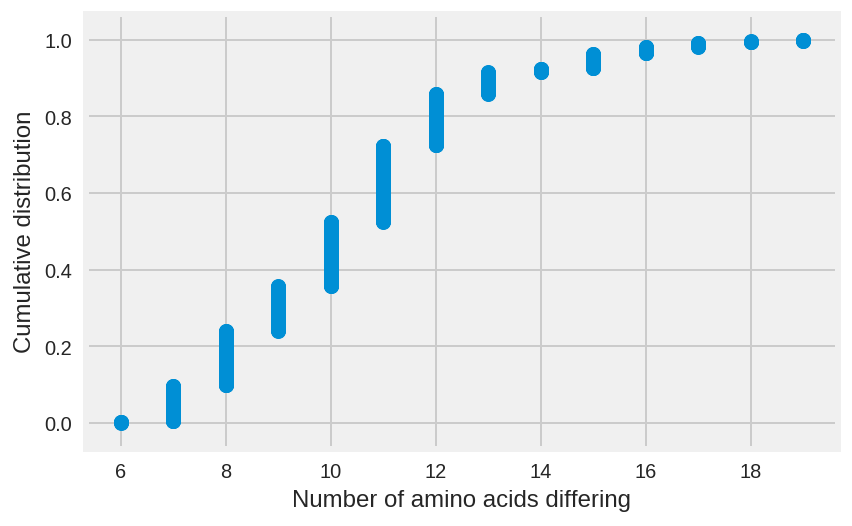

In [443]:
from Levenshtein import distance
levDs_from_preds = [distance(str(record.seq), most_probable_seq) for record in test_sequences]

def ecdf_scatter(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x, y)
    
    return ax
    
    
ax = ecdf_scatter(levDs_from_preds)
ax.set_xlabel('Number of amino acids differing')
ax.set_ylabel('Cumulative distribution')

The answer is... not really. Haha, but this is expected. Based on the last quarter, the "average" sequence is going to look a median of 11 a.a. different from any given "actual" sequences, with the spread from 6 to 18. 

A way to work around this is to not sample per quarter, but per month instead. But this would involve a crap ton of re-training... okay, maybe that's something I could do for the coming weeks instead!

# Vaccine Strain Trajectory

One big question is whether the vaccine strains have been selected well or not. Let's take a look at where the vaccine strains fall on the evolutionary trajectory plots.

In [444]:
import yaml

with open('data/vaccine_strains.yaml', 'r+') as f:
    vaccine_strains = yaml.load(f)
    
set(vaccine_strains.values())

{'A/Brisbane/10/2007',
 'A/California/7/2004',
 'A/Fujian/411/2002',
 'A/Hong Kong/4801/2014',
 'A/Moscow/10/99',
 'A/Perth/16/2009',
 'A/Switzerland/9715293/2013',
 'A/Texas/50/2012',
 'A/Victoria/361/2011',
 'A/Wisconsin/67/2005'}

In [445]:
training_metadata['Strain Name'] = training_metadata['Strain Name'].str.split('(').str[0]
training_metadata[training_metadata['Strain Name'].isin(set(vaccine_strains.values()))]

/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Name,Sequence Accession,Complete Genome,Segment,Segment Length,Subtype,Collection Date,Host Species,Country,State/Province,Flu Season,Strain Name,Unnamed: 12,coords0,coords1,coords2
1521,HA,KM978061,Yes,4,1701,H3N2,2007-06-01,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,1.996639,-2.077164,0.645289
1522,HA,CY039087,Yes,4,1717,H3N2,2007-06-01,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,1.996639,-2.077164,0.645289
1523,HA,KM821339,Yes,4,1739,H3N2,2007-06-01,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,1.857847,-1.965022,0.615769
1524,HA,KJ609214,Yes,4,1719,H3N2,2007-02-06,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,2.086244,-2.154771,0.752320
1525,HA,KM978060,Yes,4,1701,H3N2,2007-06-01,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,1.846917,-1.932853,0.670933
1526,HA,CY035022,Yes,4,1714,H3N2,2007-02-06,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,1.996639,-2.077164,0.645289
1527,HA,EU199366,Yes,4,1701,H3N2,2007-06-01,IRD:Human,Australia,-N/A-,-N/A-,A/Brisbane/10/2007,NaN,2.086244,-2.154771,0.752320
2056,HA,CY114373,Yes,4,1731,H3N2,2004-06-01,IRD:Human,USA,California,-N/A-,A/California/7/2004,NaN,1.672657,-2.446701,0.157596
2057,HA,KM821334,Yes,4,1739,H3N2,2004-06-01,IRD:Human,USA,California,-N/A-,A/California/7/2004,NaN,1.672657,-2.446701,0.157596
4219,HA,CY088483,Yes,4,1701,H3N2,2002-06-01,IRD:Human,China,-N/A-,-N/A-,A/Fujian/411/2002,NaN,0.797548,-3.386261,0.631403
